
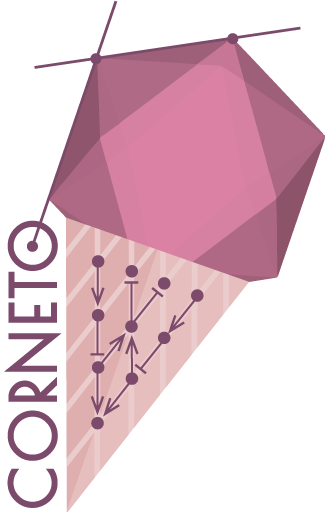

In [18]:
import cobra
import corneto as cn
import cvxpy as cp
import numpy as np
import pandas as pd
from cobra.io import load_model
from copy import deepcopy

cn.info()

In [19]:
solver = "GUROBI"
tol = 1e-6

In [20]:
G = cn.Graph.from_miom_model("https://github.com/pablormier/miom-gems/raw/refs/heads/main/gems/mitocore/v1.0.1/default.miom")
G.shape

(441, 555)

In [21]:
rxn_obj_id = next(G.get_edges_by_attr("id", "EX_biomass_e"))
rxn_obj_id

12

In [22]:
def corneto_fba(G, rxn_obj=None, min_flux=None, sparse=False):
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=1)
    F = P.expr.flow
    if sparse:
        P += cn.opt.Indicator(F)
        P.add_objectives(sum(P.expr._flow_i))
    if rxn_obj is not None:
        if isinstance(rxn_obj, str):
            rxn_obj = next(G.get_edges_by_attr("id", rxn_obj))
        if min_flux is not None:
            P += F[rxn_obj] >= min_flux
        P.add_objectives(F[rxn_obj], weights=-1)
    return P

problem = corneto_fba(G, rxn_obj=rxn_obj_id)
problem.solve(solver=solver)
opt_flux = problem.expr.flow[rxn_obj_id].value
opt_flux

100.89230387215572

In [23]:
len(np.flatnonzero(np.abs(problem.expr.flow.value)))

231

In [24]:
np.sum(np.abs(problem.expr.flow.value)>=1e-6)

231

In [25]:
problem = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
problem.solve(solver=solver)
nrxns_min = np.sum(np.abs(problem.expr.flow.value)>=tol)
nrxns_min

216

In [26]:
df_ko_result = pd.read_csv('../mitocore.csv').set_index('i')
ko_result = [(r.i, r.id, r.opt_flux, r.min_rxn) for (_, r) in df_ko_result.reset_index().iterrows()]

In [27]:
intervention_obj_effect = {k_id: flux for k_id, _, flux, _ in ko_result}

In [28]:
# Select single KOs with effects in the optimal biomass to create a pool of interesting conditions
subset_interventions = []
for k_id, r_id, opt_ko_flux, n_rxns in ko_result:
    if abs(n_rxns - nrxns_min) > 10 and opt_ko_flux > 1e-3 and opt_ko_flux <= 0.999*opt_flux:
        print(k_id, r_id, opt_ko_flux, n_rxns)
        subset_interventions.append(k_id)

9 EX_asp_L_e 100.62629856007646 204.0000533105055
18 EX_co2_e 12.916868239866858 181.00004599129625
26 EX_glc_D_e 97.40185979214648 201.00004388426865
31 EX_h_e 99.341099932917 190.00004187440737
32 EX_h2o_e 84.27054152662792 177.0000607741228
35 EX_hdca_e 49.91050423765515 272.0000708135958
39 EX_lac_L_e 100.35230090215278 204.0000438790995
47 EX_nh4_e 100.4794679320681 129.0000019452489
49 EX_o2_e 1.846509909909828 102.00003696679973
74 HEX1 97.40185979214648 201.00004388426865
76 PGI 97.84603900999088 237.0000563006875
80 TPI 97.43093092183904 201.00004736414124
81 GAPD 97.38249779574096 192.00004383995991
82 PGK 97.38249779574096 192.00004383995991
88 LDH_L 100.35230090215278 204.0000438790995
97 PDHm 98.4927588944543 194.0000768734728
98 CSm 6.581457531655777 186.00006398705256
99 ACONTm 99.0374844711101 198.00006285265715
100 ICDHxm 95.94602724560954 197.00005630237197
106 MDHm 27.885252871451897 185.0000511933078
107 CI_MitoCore 69.89555499412448 174.00004743747257
108 CII_MitoC

In [29]:
len(subset_interventions)

48

Find a network with some characteristics (e.g production of biomass) and the networks for each intervention. Assumption is that each alt. network after intervention has min. distance wrt the control network.

In [30]:
def multisparse_fba(G, interventions, obj_rxn=rxn_obj_id, lam=0,
                    opt_ko=None, max_flux=True, prop_opt_ko=1.0, beta=0, 
                    verbose=True, norel=0, time_limit=400, gap=0):
    # Maximize fba per intervention minimizing the distance across networks
    conditions = len(interventions)
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=conditions)
    P += cn.opt.Indicator(P.expr.flow)
    selected = []
    for i in range(conditions):
        F = P.expr._flow[:, i]
        sel = P.expr._flow_i[:, i]
        intv = interventions[i]
        # maximize biomass (if no info about opt ko)
        if max_flux:
            P.add_objectives(F[obj_rxn], weights=-1)
        if opt_ko is not None:
            print(f"Intervention: {intv}, FBA sol = {opt_ko[intv]}, FBA sol {prop_opt_ko*100}% = {prop_opt_ko * opt_ko[intv]}")
            #print(intv, prop_opt_ko * opt_ko[intv])
            P += F[obj_rxn] >= prop_opt_ko * opt_ko[intv]
        # Block flux on intervened reaction
        P += sel[intv] == 0 # blocked
        P += F[intv] == 0 # Redundant but can improve perf.
        selected.append(sel)
        if beta > 0:
            P.add_objectives(sum(sel), weights=beta)
    if lam > 0:
        total = sum(selected)
        P += cn.opt.linear_or(P.expr._flow_i, axis=1, varname="Y")
        P.add_objectives(sum(P.expr.Y), weights=lam)
    opt = {
        'IntegralityFocus': 1,
        'NoRelHeurTime': norel
    }
    if gap > 0:
        opt['MIPGap'] = gap
    P.solve(solver='GUROBI', verbosity=int(verbose), TimeLimit=time_limit, **opt)
    print(f"Obj for lam={lam}, b={beta}:")
    for o, w in zip(P.objectives, P.weights):
        print(o.value, w)
    print("------------")
    return P, selected


## Experiments

Sparse FBA tries to find the smallest flux consistent metabolic network that is able to attain a particular objective. For multiple conditions, taking the union of one sparse FBA per condition do not achieve optimal results. Here we show how multi-condition sparse FBA can find better networks by integrating information from multiple conditions.

We show this first for a given set of interventions, assuming we know the optimal possible FBA solution per KO.

In [31]:
np.random.seed(42)
prop_opt_ko = 0
norel=60
norel=0
timelimit=300
verbose=False
reps=5
sizes = [8]

# Generate experiments
experiments = []
for size in sizes:
    for i in range(reps):
        sel_ids = np.random.choice(subset_interventions, size, replace=False)
        experiments.append((size, i, sel_ids))

df_experiments = pd.DataFrame(experiments, columns=["size", "rep", "intv_ids"])
df_experiments

,size,rep,intv_ids
0,8,0,"[171, 483, 170, 488, 111, 469, 81, 106]"
1,8,1,"[485, 109, 26, 412, 9, 170, 483, 486]"
2,8,2,"[81, 485, 172, 31, 35, 408, 108, 170]"
3,8,3,"[482, 82, 100, 97, 408, 483, 506, 469]"
4,8,4,"[81, 97, 469, 418, 39, 47, 74, 82]"


In [32]:
def run_experiments(experiments, prop_opt_ko=prop_opt_ko, lam=0.0):
    results = []
    for i, r in experiments.iterrows():
        sel_ids = r.intv_ids
        print(f"k={r.size} (row {i}), selected interventions: {sel_ids}")
        Mm = multisparse_fba(G, sel_ids, lam=lam, beta=0, obj_rxn=rxn_obj_id, verbose=verbose, norel=norel,
                             time_limit=timelimit, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko)
        Nm = (np.abs(Mm[0].expr.flow.value) >= tol).astype(int)
        Fm = Mm[0].expr.flow.value
        mean_obj_flux = np.mean(Fm[rxn_obj_id, :])
        rxn_multi = sum(np.mean(Nm, axis=1) > 0)
        results.append((r.rep, lam, mean_obj_flux, rxn_multi))
    return results

In [33]:
all_results = []
for lam in list(np.geomspace(1e-3, 6, 10)):
    print("Lambda:", lam)
    # There are 10 different subsets of 4-sample setting with different KOs
    results = run_experiments(df_experiments, prop_opt_ko=prop_opt_ko, lam=lam)
    all_results.extend(results)

df_r = pd.DataFrame(all_results, columns=["exp", "lambda", "avg_flux", "size_union"])

Lambda: 0.001
k=3 (row 0), selected interventions: [171 483 170 488 111 469  81 106]
Intervention: 171, FBA sol = 48.27050695790599, FBA sol 0% = 0.0
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 0% = 0.0
Intervention: 170, FBA sol = 48.27050695790599, FBA sol 0% = 0.0
Intervention: 488, FBA sol = 100.35230090215278, FBA sol 0% = 0.0
Intervention: 111, FBA sol = 7.563630434782663, FBA sol 0% = 0.0
Intervention: 469, FBA sol = 1.8465099099098552, FBA sol 0% = 0.0
Intervention: 81, FBA sol = 97.38249779574096, FBA sol 0% = 0.0
Intervention: 106, FBA sol = 27.885252871451897, FBA sol 0% = 0.0
Obj for lam=0.001, b=0:
48.27021506601507 -1
12.916868239868236 -1
48.27021506601507 -1
100.35225225350445 -1
7.560891304347717 -1
1.8464612612612612 -1
97.38244914709264 -1
27.88525287145287 -1
278.0 0.001
------------
k=3 (row 1), selected interventions: [485 109  26 412   9 170 483 486]
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 0% = 0.0
Intervention: 109, FBA sol = 2.10262

In [34]:
df_r.to_csv("pareto_results_8cond_5reps_multi.csv")